In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform




In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio("../content/gdrive/My Drive/brain tumor dataset", output="output", seed=1337, ratio=(.8, 0.1,0.1))


Copying files: 253 files [00:00, 459.09 files/s]


In [ ]:
train_path="/content/output/train"
val_path="/content/output/val"
test_path="/content/output/test"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

list = os.listdir("/content/output/train/yes") + os.listdir("/content/output/train/no")
Total_Traindata = len(list)

list = os.listdir("/content/output/val/yes") + os.listdir("/content/output/val/no")
Total_Valdata = len(list)

list = os.listdir("/content/output/test/yes") + os.listdir("/content/output/test/no")
Total_Testdata = len(list)

print (Total_Traindata)
print (Total_Valdata)
print (Total_Testdata)

202
24
27


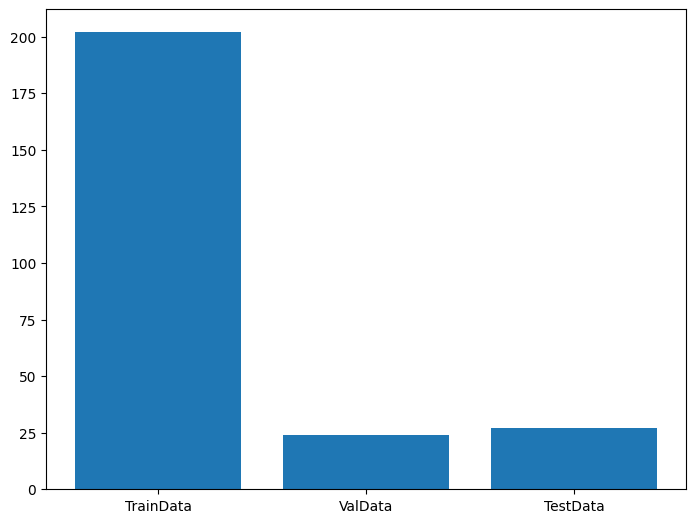

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['TrainData', 'ValData', 'TestData']
Data = [Total_Traindata,Total_Valdata,Total_Testdata ]
ax.bar(langs,Data)
plt.show()


In [ ]:
labels = []
for i in os.listdir(train_path):
    labels+=[i]

In [ ]:
labels

['yes', 'masks', 'brain_tumor_dataset', 'no', 'images']

In [ ]:
import random
import matplotlib.image as mpimg
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_path,target_size=(331, 331),batch_size=32,shuffle=True,class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_path,target_size=(331,331),batch_size=32,shuffle=False,class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_path,target_size=(331,331),batch_size=32,shuffle=False,class_mode='binary')


Found 5104 images belonging to 5 classes.
Found 636 images belonging to 5 classes.
Found 641 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import  NASNetLarge

model = NASNetLarge(
      input_shape = (331,331,3),
      include_top = False,
      weights = 'imagenet'
    )

In [ ]:
for layers in model.layers:
    layers.trainable = False

In [ ]:
from keras.layers import  Dropout
x = Flatten()(model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation = "sigmoid")(x)

model = keras.Model(model.input, x)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                           

In [ ]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [ ]:
mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='max' )

In [ ]:
History = model.fit_generator(train_generator,validation_data = val_generator, epochs = 100, verbose=1,callbacks=[mc,es])

In [ ]:
hist = History.history

In [ ]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
model.load_weights("/content/gdrive/My Drive/best_model.h5")

In [ ]:
model.evaluate_generator(test_generator)

In [ ]:
from cv2 import imread
yes_path = test_path+"/yes/"+os.listdir(test_path+"/yes/")[9]

tumour = imread(yes_path)
image_resized= cv2.resize(tumour, (331 ,331))
image=np.expand_dims(image_resized,axis=0)
plt.imshow(tumour)

In [ ]:
pred=model.predict(image)

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)